In [148]:
import rdflib as rdf
from rdflib.extras.external_graph_libs import rdflib_to_networkx_multidigraph
import networkx as nx
import matplotlib.pyplot as plt
from SPARQLWrapper import SPARQLWrapper, JSON

In [2]:
# Plot Networkx instance of RDF Graphpos = nx.spring_layout(G, scale=2)
def plot(result):
    G = rdflib_to_networkx_multidigraph(result)
    pos = nx.spring_layout(G, scale=200)
    edge_labels = nx.get_edge_attributes(G, 'r')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    nx.draw(G, with_labels=True)

    #if not in interactive mode for 
    plt.show()

In [3]:
def query(q):
    sparql = SPARQLWrapper("http://dbpedia.org/sparql")
    sparql.setQuery(q)
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()
    return results["results"]["bindings"]

In [127]:
def extract_En_URI(result,string):
    if ("xml:lang" in result[string]): 
        if (result[string]["xml:lang"] == "en" ):
            return result[string]["value"]
    else:
        return result[string]["value"]

In [299]:
songs="""
Select DISTINCT ?song 
    WHERE{
    ?song rdf:type dbo:Song.
    ?song dbo:wikiPageWikiLink ?link.
    Filter(
    ?link=dbr:Grammy_Award_for_Song_of_the_Year ||
    ?link=dbr:The_500_Greatest_Songs_of_All_Time ||
    ?link=dbc:Single_Top_100_number-one_singles ||
    ?link=dbc:European_Hot_100_Singles_number-one_singles
    ).
    ?song dbo:album ?album.
    ?song dbo:artist ?artist.
    ?song dbo:genre ?genre.
    ?song dbo:producer ?producer.
    ?song dbo:writer ?writer.
    }
    """
resultsq1=query(songs)
songsURIs=[]
for result in resultsq1:
    songsURIs.append(result["song"]["value"])
len(songsURIs)

613

In [300]:
source="http://dbpedia.org/ontology/"
resource="http://dbpedia.org/resource/"
resourceURI= rdf.URIRef(resource)
prop= rdf.URIRef(source)
mo= rdf.URIRef(source+"MusicGenre")
labelURI = "http://www.w3.org/2000/01/rdf-schema#label"
albumURI = source+"album"
artistURI = source+"artist"
genreURI = source+"genre"
lengthURI = source+"length"
producerURI = source+"producer"
writerURI = source+"writer"
releasedURI = source+"releaseDate"
catGrammy= resource+"Grammy_Award_for_Song_of_the_Year"
catURI = source+"wikiPageWikiLink"
URIs=[labelURI,albumURI ,artistURI ,genreURI ,lengthURI,producerURI ,writerURI,releasedURI]
numericURIs=[labelURI,releasedURI ,lengthURI]

Gmusic=rdf.Graph()
Gmusic.bind("property", prop)
Gmusic.bind("resource", resourceURI)
# Gmusic.bind("Music", mo)

for song in songsURIs:
    q='\nselect distinct ?property ?value where {\n  <' + song +'> ?property ?value .\n  filter ( ?property not in ( rdf:type ) )\n}'
    results=query(q)
    songURI = rdf.URIRef(song)
    Gmusic.add((songURI,rdf.RDF.type,mo))
    for result in results:
        URI= result["property"]["value"]
        if URI in URIs:
            propURI=extract_En_URI(result,"value")
            if (propURI!= None): 
                if(URI not in numericURIs):
                    uri=rdf.URIRef(URI)
#                     Gmusic.add((songURI,uri,rdf.URIRef(propURI)))
                    q='\nselect distinct ?label where {\n  <' + propURI +'> rdfs:label ?label.}'
                    labels=query(q)
                    for label in labels:
                        if(extract_En_URI(label,"label")!=None): engLabel=extract_En_URI(label,"label")
                    if engLabel!=None:
                        Gmusic.add((songURI,uri,rdf.Literal(engLabel)))
                else:
                    Gmusic.add((songURI,rdf.URIRef(URI),rdf.Literal(propURI)))
        elif (URI==catURI) & (catGrammy== result["value"]["value"]):
                Gmusic.add((songURI,rdf.URIRef(catGrammy),rdf.Literal("Grammy")))
                


In [301]:
f = open("songs.xml", "wb")
xml=Gmusic.serialize(format='xml')
f.write(xml)
f.close()

In [302]:
g = rdf.Graph()
g.parse("songs.xml")

<Graph identifier=N6370402bbf894f7d94ad17151fb54090 (<class 'rdflib.graph.Graph'>)>

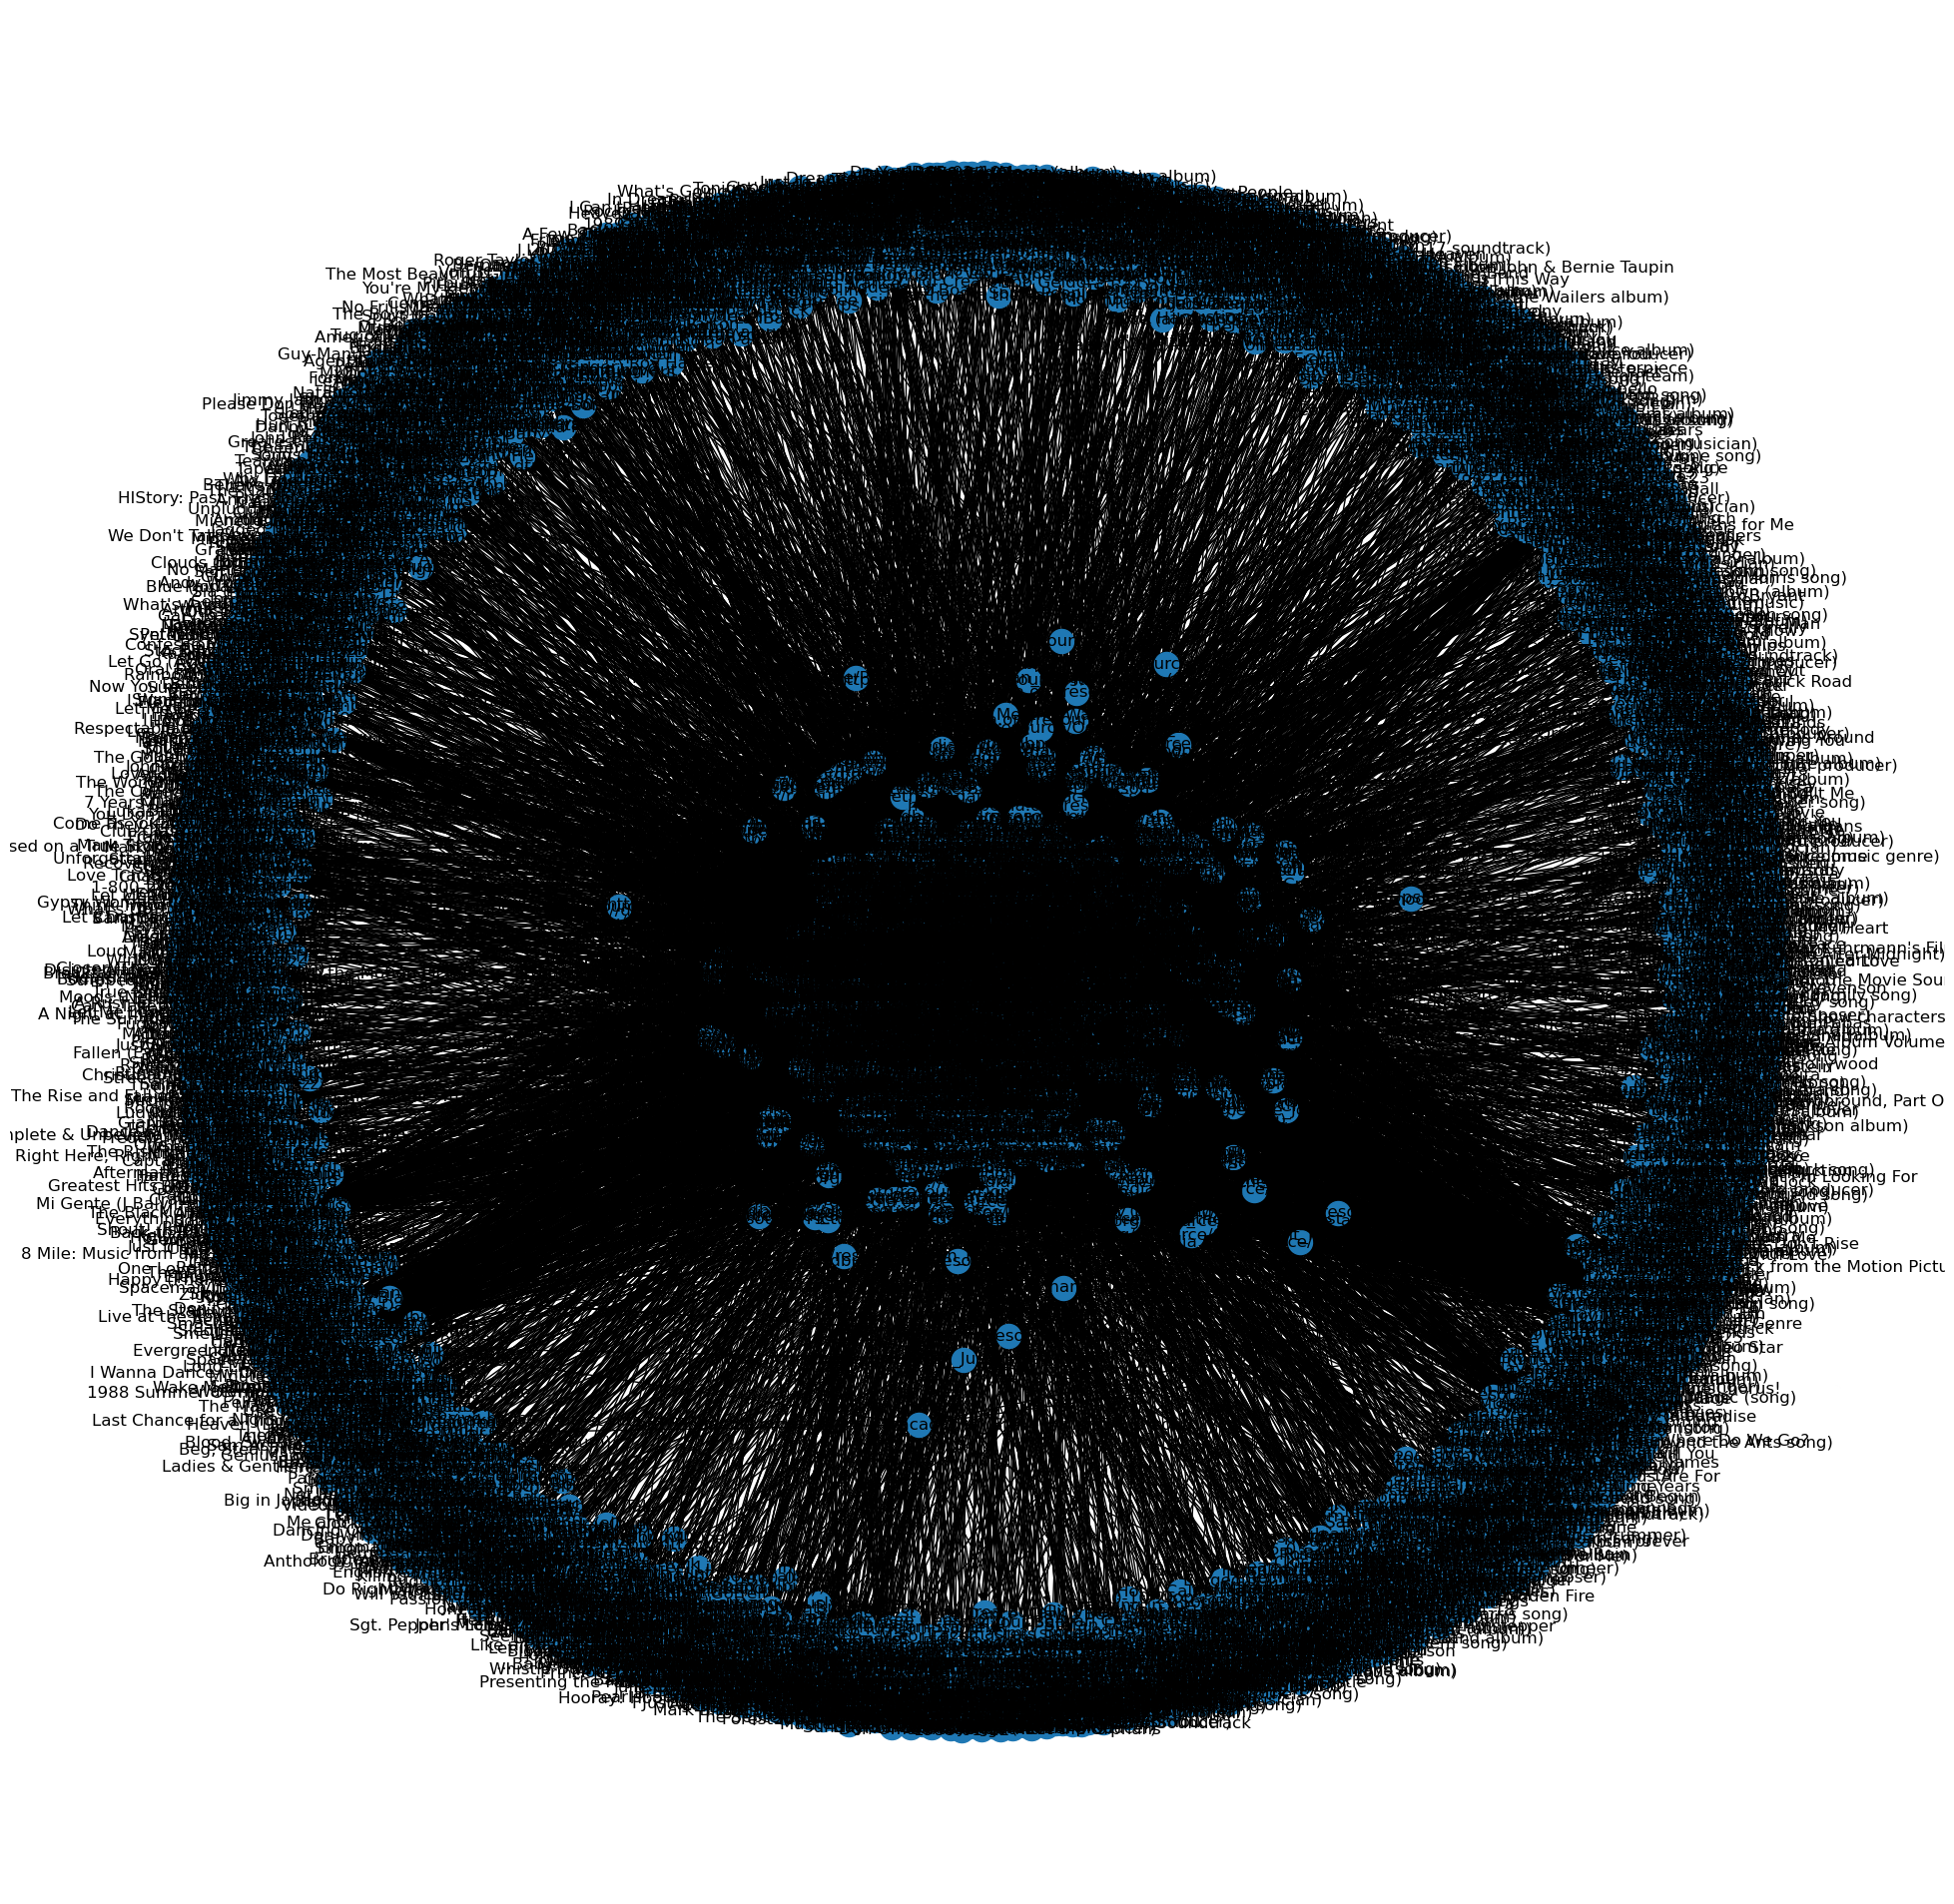

In [303]:

plt.figure(figsize=(25, 25), dpi=100)
plot(Gmusic)

# 1-What is the name of the album of  _"SONG"_ ?

In [304]:
song="'Roar (song)'" # The string should be doubled
q = "\n SELECT distinct ?album \n  WHERE {\n    ?song rdfs:label "+song+".\n ?song property:album ?album .\n }\n"

R=Gmusic.query(q)
for r in R :
    print(r["album"])

Prism (Katy Perry album)


# 2-What is the artist of _"SONG"_?

In [305]:
song="'Roar (song)'" # The string should be doubled
q = "\n SELECT distinct ?artist \n  WHERE {\n    ?song rdfs:label "+song+".\n ?song property:artist ?artist .\n }\n"

R=Gmusic.query(q)
print(len(R))
for r in R :
    print(r["artist"])

1
Katy Perry


# 3-In what genre is _"SONG"_ from?

In [306]:
song="'Roar (song)'" # The string should be doubled
q = "\n SELECT distinct ?genre \n  WHERE {\n    ?song rdfs:label "+song+".\n ?song property:genre ?genre .\n }\n"

R=Gmusic.query(q)
print(len(R))
for r in R :
    print(r["genre"])

1
Pop music


# 4-Who is the producer of _"SONG"_?


In [307]:
song="'Roar (song)'" # The string should be doubled
q = "\n SELECT distinct ?producer \n  WHERE {\n    ?song rdfs:label "+song+".\n ?song property:producer ?producer .\n }\n"

R=Gmusic.query(q)
print(len(R))
for r in R :
    print(r["producer"])

3
Cirkut
Dr. Luke
Max Martin


# 5-Who wrote the lyrics _"SONG"_?


In [308]:
song="'Roar (song)'" # The string should be doubled
q = "\n SELECT distinct ?writer \n  WHERE {\n    ?song rdfs:label "+song+".\n ?song property:writer ?writer .\n }\n"

R=Gmusic.query(q)
print(len(R))
for r in R :
    print(r["writer"])

5
Max Martin
Cirkut
Dr. Luke
Bonnie McKee
Katy Perry


# 6-When was _"SONG"_ realeased ?


In [309]:
song="'Infinity (Guru Josh song)'" # The string should be doubled
q = "SELECT distinct ?releaseDate\n WHERE {\n?song rdfs:label "+song+".\n ?song property:releaseDate ?releaseDate.\n }\n"

R=Gmusic.query(q)
print(len(R))
for r in R :
    print(r["releaseDate"])

1
1989-12-18


# 7-Which song of these was sang by _"artist"_ ?

In [310]:
artist="'Billie Eilish'" # The string should be doubled
q = "\n SELECT distinct ?artist ?label\n  WHERE {\n    ?song rdfs:label ?label.\n ?song property:artist "+artist+" .\n }\n"

R=Gmusic.query(q)
for r in R :
    print(r["label"])

Bad Guy (Billie Eilish song)


# 8-How many Artists sang _"SONG"_ ?

In [311]:
song="'Lady Marmalade'" # The string should be doubled
q = "\n SELECT distinct (count(?artist) as ?count) \n  WHERE {\n    ?song rdfs:label "+song+".\n ?song property:artist ?artist .\n }\n"

R=Gmusic.query(q)
for r in R :
    print(r["count"])

7


# 9-How many Artists wrote _"SONG"_ ?

In [312]:
song="'Roar (song)'" # The string should be doubled
q = "\n SELECT distinct (count(?writer) as ?count) \n  WHERE {\n    ?song rdfs:label "+song+".\n ?song property:writer ?writer .\n }\n"

R=Gmusic.query(q)
for r in R :
    print(r["count"])

5


# 10-Which song of these has a grammy award?

In [313]:
q = """
    Select DISTINCT ?label 
    WHERE{
    ?song rdfs:label ?label.
    ?song resource:Grammy_Award_for_Song_of_the_Year ?Grammy.
    }"""
R=Gmusic.query(q)
print(len(R))
for r in R :
    print(r["label"])

145
This Masquerade
Beautiful Day
Nobody Does It Better
Breathe (Faith Hill song)
Viva la Vida
See You Again
I Believe I Can Fly
Need You Now (Lady Antebellum song)
A Whole New World
Bad Guy (Billie Eilish song)
1-800-273-8255 (song)
Love Yourself
American Boy
Complicated (Avril Lavigne song)
I Just Called to Say I Love You
Put Your Records On
Hold On (Wilson Phillips song)
Baby Baby (Amy Grant song)
Formation (song)
That's What Friends Are For
Hello (Adele song)
Poker Face (Lady Gaga song)
Afternoon Delight
God's Plan (song)
Roar (song)
Stay with Me (Sam Smith song)
The September of My Years
The Joke (song)
Just Give Me a Reason
Don't Know Why
Give Me One Reason
You're So Vain
The A Team (Ed Sheeran song)
Honesty (Billy Joel song)
Fallin' (Alicia Keys song)
The Living Years
The First Time Ever I Saw Your Face
Wind Beneath My Wings
Song Sung Blue
Unforgettable (Nat King Cole song)
I.G.Y. (What a Beautiful World)
Moon River
What a Fool Believes
Say My Name
Beauty and the Beast (Disney s